<a href="https://colab.research.google.com/github/monishreddy1321/Audio_Classification/blob/main/Audio_ANN_fold_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install audiomentations

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from sklearn.metrics import classification_report

# --- PARAMETERS ---
AUDIO_DIR = '/content/UrbanSound8K'  # Replace with your actual directory
SAMPLE_RATE = 22050
NUM_FOLDS = 10

# --- FEATURE EXTRACTION FUNCTION ---
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    rmse = librosa.feature.rms(y=audio)
    combined = np.hstack([
        np.mean(mfcc.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(zcr.T, axis=0),
        np.mean(contrast.T, axis=0),
        np.mean(rmse.T, axis=0)
    ])
    return combined

# --- LOAD ALL FEATURES AND LABELS ---
features = []
labels = []
file_paths = []

# Update the iteration to match your directory structure
for filename in os.listdir(AUDIO_DIR):  # Iterate directly through audio files
    if filename.endswith(".wav"):
        file_path = os.path.join(AUDIO_DIR, filename)
        try:
            feat = extract_features(file_path)
            label = int(filename.split('-')[1])  # Extract class from filename
            features.append(feat)
            labels.append(label)
            file_paths.append(file_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

features = np.array(features)
labels = np.array(labels)

#Step 3: Data Augmentation (Not used in this example, but you can add it later)
#from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch
#augment = Compose([
#    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
#    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
#])

# --- K-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_idx, val_idx in kf.split(features, labels):
    print(f"\n--- Fold {fold_no} ---")
    X_train, X_val = features[train_idx], features[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Build model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early],
        verbose=1
    )

    # Evaluate model
    scores = model.evaluate(X_val_scaled, y_val, verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]:.4f} - Accuracy: {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    y_val_pred = np.argmax(model.predict(X_val_scaled), axis=1)

    # Print classification report for this fold
    print(f"\nClassification Report for Fold {fold_no}:")
    print(classification_report(y_val, y_val_pred, digits=4))

    # Save model and scaler for this fold
    model.save(f'model_fold_{fold_no}.keras')
    joblib.dump(scaler, f'scaler_fold_{fold_no}.pkl')
    print(f"Saved model_fold_{fold_no}.keras and scaler_fold_{fold_no}.pkl")

    fold_no += 1

# --- PRINT SUMMARY ---
print('\n--- Cross-Validation Results ---')
for i in range(NUM_FOLDS):
    print(f"Fold {i+1}: Loss = {loss_per_fold[i]:.4f}, Accuracy = {acc_per_fold[i]:.2f}%")
print(f"Average Accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)")
print(f"Average Loss: {np.mean(loss_per_fold):.4f}")

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2236 - loss: 2.2699 - val_accuracy: 0.6286 - val_loss: 1.8157
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5420 - loss: 1.3845 - val_accuracy: 0.7714 - val_loss: 1.4732
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7068 - loss: 0.8882 - val_accuracy: 0.8000 - val_loss: 1.2339
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8033 - loss: 0.6026 - val_accuracy: 0.8286 - val_loss: 1.0922
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8351 - loss: 0.5249 - val_accuracy: 0.7714 - val_loss: 0.9837
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8830 - loss: 0.4206 - val_accuracy: 0.8571 - val_loss: 0.8488
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9071 - loss: 0.3526 - val_accuracy: 0.8857 - val_loss: 0.7599
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9126 - loss: 0.2906 - val_accuracy: 0.8857 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2520 - loss: 2.4514 - val_accuracy: 0.4571 - val_loss: 1.7662
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4900 - loss: 1.5609 - val_accuracy: 0.6000 - val_loss: 1.5416
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6690 - loss: 1.0727 - val_accuracy: 0.7429 - val_loss: 1.3461
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7385 - loss: 0.7808 - val_accuracy: 0.8000 - val_loss: 1.1838
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8378 - loss: 0.5775 - val_accuracy: 0.8571 - val_loss: 1.0232
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8475 - loss: 0.4741 - val_accuracy: 0.8857 - val_loss: 0.8923
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8995 - loss: 0.3885 - val_accuracy: 0.8857 - val_loss: 0.7959
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9139 - loss: 0.3314 - val_accuracy: 0.8857 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1446 - loss: 2.8593 - val_accuracy: 0.4286 - val_loss: 1.9242
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5480 - loss: 1.5344 - val_accuracy: 0.4571 - val_loss: 1.6777
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6452 - loss: 1.0332 - val_accuracy: 0.5429 - val_loss: 1.5014
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7517 - loss: 0.9041 - val_accuracy: 0.6857 - val_loss: 1.3125
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7964 - loss: 0.7192 - val_accuracy: 0.8286 - val_loss: 1.1303
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8339 - loss: 0.5494 - val_accuracy: 0.8857 - val_loss: 0.9819
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8790 - loss: 0.4916 - val_accuracy: 0.9429 - val_loss: 0.8586
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8844 - loss: 0.3651 - val_accuracy: 0.9143 - val_loss: 0.

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Classification Report for Fold 3:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         6
           2     1.0000    1.0000    1.0000         6
           3     1.0000    0.5000    0.6667         2
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         4
           6     1.0000    1.0000    1.0000         2
           7     1.0000    1.0000    1.0000         2
           8     1.0000    1.0000    1.0000         3
           9     0.8333    1.0000    0.9091         5

    accuracy                         0.9714        35
   macro avg     0.9815    0.9444    0.9529        35
weighted avg     0.9762    0.9714    0.9680        35

Saved model_fold_3.keras and scaler_fold_3.pkl

--- Fold 4 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1966 - loss: 2.3991 - val_accuracy: 0.6000 - val_loss: 1.7526
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5150 - loss: 1.4721 - val_accuracy: 0.7714 - val_loss: 1.3997
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6221 - loss: 1.0780 - val_accuracy: 0.8571 - val_loss: 1.1502
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7195 - loss: 0.8012 - val_accuracy: 0.8857 - val_loss: 0.9610
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7912 - loss: 0.6791 - val_accuracy: 0.8571 - val_loss: 0.8267
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8660 - loss: 0.4800 - val_accuracy: 0.8857 - val_loss: 0.7028
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8859 - loss: 0.3914 - val_accuracy: 0.8857 - val_loss: 0.6139
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8826 - loss: 0.3667 - val_accuracy: 0.9429 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1695 - loss: 2.6026 - val_accuracy: 0.4857 - val_loss: 1.7898
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5310 - loss: 1.4863 - val_accuracy: 0.6857 - val_loss: 1.4602
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6786 - loss: 1.0535 - val_accuracy: 0.7714 - val_loss: 1.2370
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7339 - loss: 0.7887 - val_accuracy: 0.8571 - val_loss: 1.0436
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8134 - loss: 0.6647 - val_accuracy: 0.8857 - val_loss: 0.8805
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8405 - loss: 0.6342 - val_accuracy: 0.9429 - val_loss: 0.7302
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8698 - loss: 0.4708 - val_accuracy: 0.9429 - val_loss: 0.6201
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8976 - loss: 0.3364 - val_accuracy: 0.9429 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.1557 - loss: 2.5775 - val_accuracy: 0.4286 - val_loss: 1.9415
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4946 - loss: 1.5120 - val_accuracy: 0.4857 - val_loss: 1.7429
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6957 - loss: 1.0618 - val_accuracy: 0.6857 - val_loss: 1.5434
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7545 - loss: 0.8705 - val_accuracy: 0.7714 - val_loss: 1.3520
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8522 - loss: 0.6375 - val_accuracy: 0.8857 - val_loss: 1.1692
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8405 - loss: 0.5813 - val_accuracy: 0.9143 - val_loss: 1.0039
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8736 - loss: 0.4255 - val_accuracy: 0.9143 - val_loss: 0.8618
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8791 - loss: 0.4011 - val_accuracy: 0.9143 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1649 - loss: 2.7960 - val_accuracy: 0.4857 - val_loss: 1.7733
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5360 - loss: 1.3820 - val_accuracy: 0.6571 - val_loss: 1.5008
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6599 - loss: 1.0634 - val_accuracy: 0.7429 - val_loss: 1.3091
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7577 - loss: 0.7244 - val_accuracy: 0.7429 - val_loss: 1.1378
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8095 - loss: 0.6120 - val_accuracy: 0.7714 - val_loss: 1.0142
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8477 - loss: 0.4553 - val_accuracy: 0.8571 - val_loss: 0.9093
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8908 - loss: 0.3781 - val_accuracy: 0.8571 - val_loss: 0.8127
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9301 - loss: 0.2950 - val_accuracy: 0.8286 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2572 - loss: 2.3590 - val_accuracy: 0.6000 - val_loss: 1.8131
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5215 - loss: 1.3516 - val_accuracy: 0.6571 - val_loss: 1.5113
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6960 - loss: 0.9759 - val_accuracy: 0.7143 - val_loss: 1.3313
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7826 - loss: 0.7694 - val_accuracy: 0.8286 - val_loss: 1.1754
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8000 - loss: 0.6169 - val_accuracy: 0.8857 - val_loss: 1.0118
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8632 - loss: 0.4641 - val_accuracy: 0.9143 - val_loss: 0.8652
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8719 - loss: 0.3986 - val_accuracy: 0.9143 - val_loss: 0.7595
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9015 - loss: 0.3117 - val_accuracy: 0.9714 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0963 - loss: 2.8848 - val_accuracy: 0.3714 - val_loss: 2.0710
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4888 - loss: 1.5164 - val_accuracy: 0.5143 - val_loss: 1.8081
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6234 - loss: 1.0992 - val_accuracy: 0.6000 - val_loss: 1.5210
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7705 - loss: 0.8648 - val_accuracy: 0.7429 - val_loss: 1.2540
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8127 - loss: 0.6203 - val_accuracy: 0.8286 - val_loss: 1.0219
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8195 - loss: 0.5756 - val_accuracy: 0.9714 - val_loss: 0.8188
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8648 - loss: 0.4505 - val_accuracy: 0.9714 - val_loss: 0.6818
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9043 - loss: 0.3887 - val_accuracy: 0.9714 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1717 - loss: 2.8058 - val_accuracy: 0.5429 - val_loss: 1.7780
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5098 - loss: 1.5475 - val_accuracy: 0.7429 - val_loss: 1.3940
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6386 - loss: 1.1165 - val_accuracy: 0.8000 - val_loss: 1.1273
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7631 - loss: 0.8908 - val_accuracy: 0.9143 - val_loss: 0.9175
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8139 - loss: 0.6108 - val_accuracy: 0.9429 - val_loss: 0.7783
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8583 - loss: 0.5175 - val_accuracy: 0.9429 - val_loss: 0.6792
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9029 - loss: 0.3758 - val_accuracy: 0.9714 - val_loss: 0.5448
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9183 - loss: 0.3526 - val_accuracy: 1.0000 - val_loss: 0.

##Prediction and play

In [ ]:
from tensorflow.keras.models import load_model
import joblib

# Load the trained model and scaler
model = load_model('/content/model_fold_8.keras')          # or whichever fold/model you want
scaler = joblib.load('/content/scaler_fold_8.pkl')         # matching scaler for the model


In [ ]:
import librosa
import numpy as np

SAMPLE_RATE = 22050

def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    rmse = librosa.feature.rms(y=audio)
    combined = np.hstack([
        np.mean(mfcc.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(zcr.T, axis=0),
        np.mean(contrast.T, axis=0),
        np.mean(rmse.T, axis=0)
    ])
    return combined


In [ ]:
# Class ID mapping
class_map = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music"
}

def predict_audio_class(audio_path):
    # Extract and scale features
    features = extract_features(audio_path)
    features_scaled = scaler.transform([features])
    # Predict
    pred = model.predict(features_scaled)
    class_id = np.argmax(pred, axis=1)[0]
    class_name = class_map[class_id]
    print(f"Predicted class: {class_id} - {class_name}")
    return class_id, class_name


In [ ]:
from IPython.display import Audio, display

def play_audio(audio_path):
    display(Audio(audio_path, autoplay=False))


In [ ]:
audio_file = '/content/drive/MyDrive/audio/fold3/180960-6-0-0.wav'  # Replace with your test file path

# Predict class
predict_audio_class(audio_file)

# Play audio
play_audio(audio_file)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted class: 6 - gun_shot


## Stats 📈

In [ ]:
print("Features used for model training:")
print("- MFCCs (40 mean coefficients)")
print("- Chroma (12 mean coefficients)")
print("- Zero Crossing Rate (1 mean value)")
print("- Spectral Contrast (7 mean coefficients)")
print("- Root Mean Square Energy (1 mean value)")
print(f"Total features per sample: 40 + 12 + 1 + 7 + 1 = 61")


Features used for model training:
- MFCCs (40 mean coefficients)
- Chroma (12 mean coefficients)
- Zero Crossing Rate (1 mean value)
- Spectral Contrast (7 mean coefficients)
- Root Mean Square Energy (1 mean value)
Total features per sample: 40 + 12 + 1 + 7 + 1 = 61


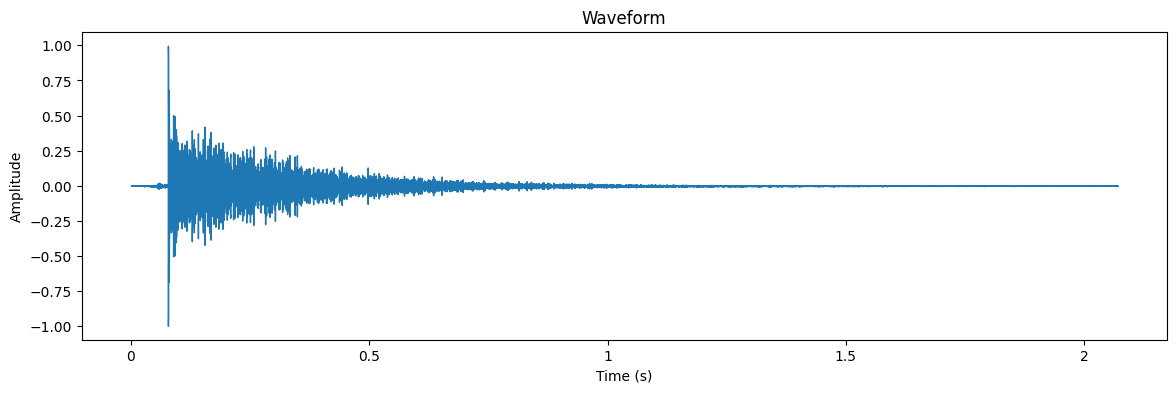

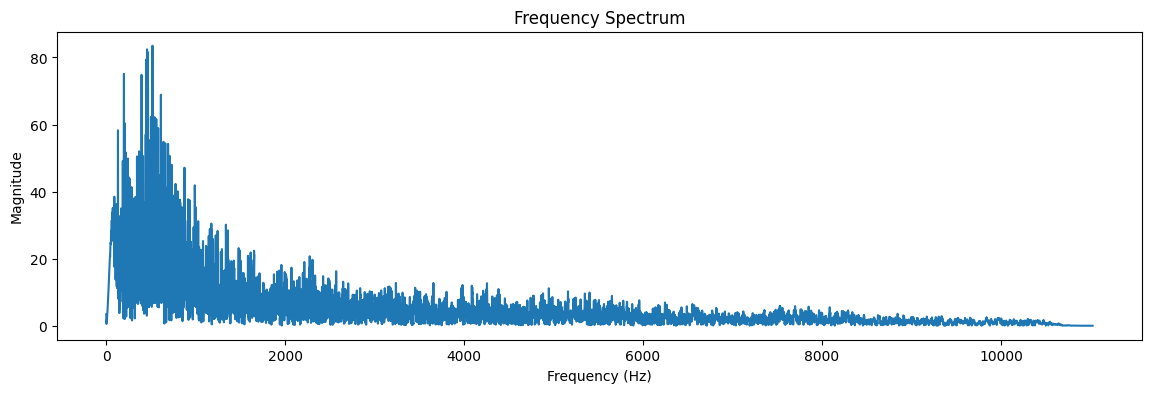

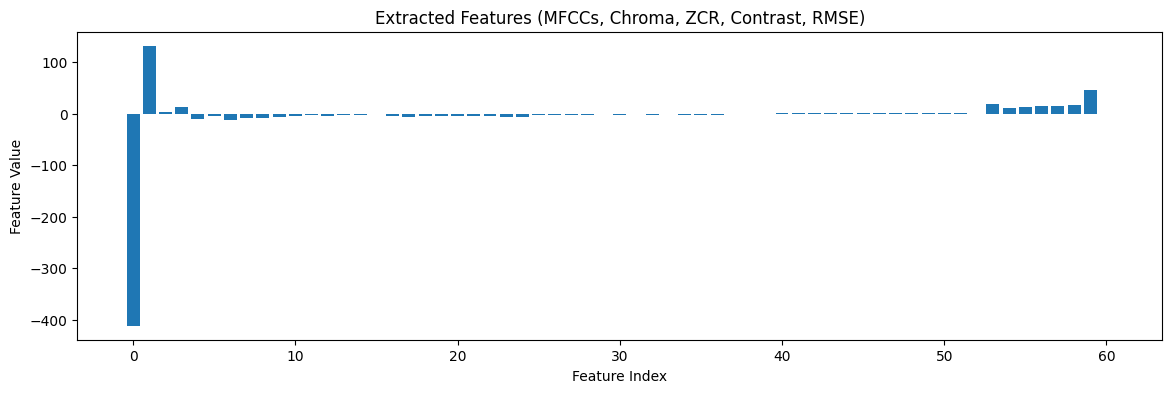

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Replace with your test audio path
test_audio_path = '/content/drive/MyDrive/audio/fold3/180960-6-0-0.wav'

# Load audio
audio, sr = librosa.load(test_audio_path, sr=22050)

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot frequency spectrum
plt.figure(figsize=(14, 4))
fft = np.fft.fft(audio)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
plt.plot(frequency[:len(magnitude)//2], magnitude[:len(magnitude)//2])
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

# Extract features
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    rmse = librosa.feature.rms(y=audio)
    combined = np.hstack([
        np.mean(mfcc.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(zcr.T, axis=0),
        np.mean(contrast.T, axis=0),
        np.mean(rmse.T, axis=0)
    ])
    return combined

features = extract_features(test_audio_path)

# Plot features as bar chart
plt.figure(figsize=(14, 4))
plt.bar(np.arange(len(features)), features)
plt.title('Extracted Features (MFCCs, Chroma, ZCR, Contrast, RMSE)')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()
